2025-08-01 12:05:22.674 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-08-01 12:05:22.676 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-08-01 12:05:22.677 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-01 12:05:23.328 
  command:

    streamlit run C:\Users\sagni\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-08-01 12:05:23.329 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-01 12:05:23.330 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-01 12:05:23.331 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-01 12:05:23.9

DeltaGenerator()

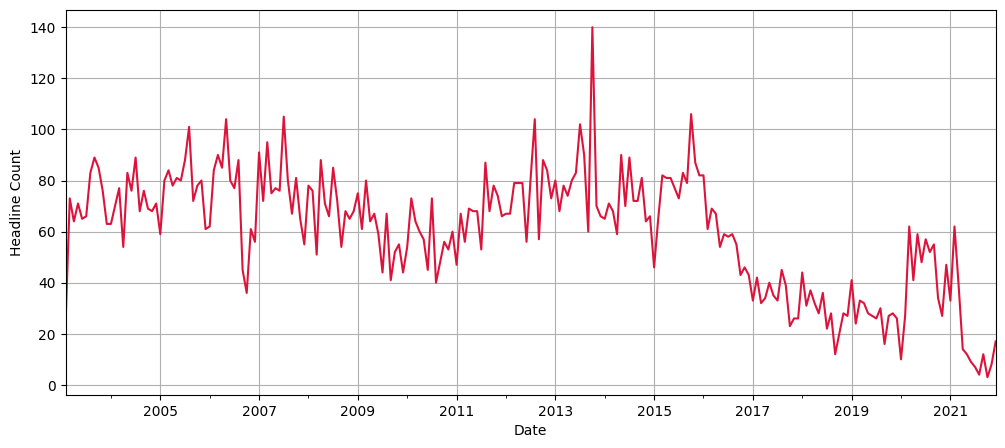

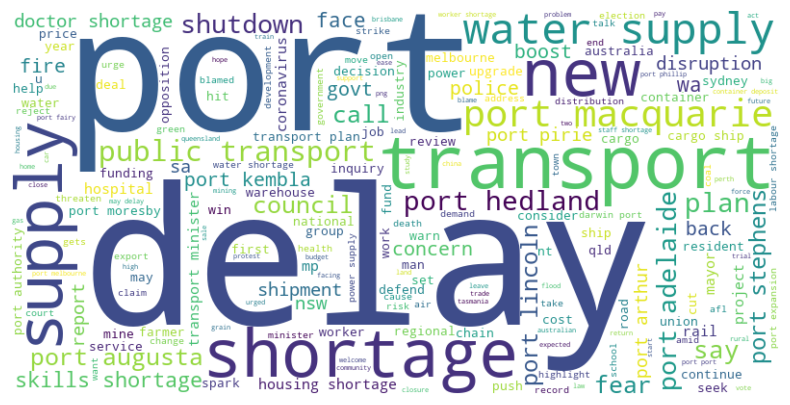

In [2]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Load data
@st.cache_data
def load_data():
    df = pd.read_csv("C:/Users/sagni/Downloads/Supply Chain Disraption/abcnews-date-text.csv")
    df['publish_date'] = pd.to_datetime(df['publish_date'], format='%Y%m%d')
    return df

df = load_data()

# Preprocess text
nltk.download('stopwords')
stop_words = stopwords.words('english')

def preprocess(text):
    return [word for word in text.lower().split() if word.isalpha() and word not in stop_words]

df['tokens'] = df['headline_text'].astype(str).apply(preprocess)

# Define disruption-related keywords
keywords = [
    'disruption', 'shortage', 'delay', 'supply', 'chain', 'logistics',
    'shutdown', 'transport', 'cargo', 'container', 'shipment', 'port',
    'warehouse', 'distribution'
]

# Filter headlines
def is_disruption(text):
    return any(kw in text for kw in keywords)

df['is_disruption'] = df['tokens'].apply(is_disruption)
disruption_df = df[df['is_disruption']]
monthly_counts = disruption_df.resample('M', on='publish_date').size()

# Sidebar
st.sidebar.title("Supply Chain Disruption Dashboard")
st.sidebar.markdown("Use this tool to explore news trends and topics related to supply chain disruptions.")

# Main
st.title("📰 Supply Chain Disruption News Analysis")

st.subheader("1️⃣ Disruption Trend Over Time")
fig, ax = plt.subplots(figsize=(12, 5))
monthly_counts.plot(ax=ax, color='crimson')
plt.xlabel("Date")
plt.ylabel("Headline Count")
plt.grid(True)
st.pyplot(fig)

st.subheader("2️⃣ Top 5 Topics from News Headlines (LDA)")

# Topic modeling
texts = df['tokens'].apply(lambda x: ' '.join(x))
vectorizer = CountVectorizer(max_df=0.95, min_df=2)
dtm = vectorizer.fit_transform(texts)
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

words = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    st.markdown(f"**Topic {idx + 1}:** " + " | ".join([words[i] for i in topic.argsort()[-10:][::-1]]))

st.subheader("3️⃣ Word Cloud for Disruption-Related Headlines")
wc_text = ' '.join([' '.join(tokens) for tokens in disruption_df['tokens']])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wc_text)
fig_wc, ax_wc = plt.subplots(figsize=(10, 5))
ax_wc.imshow(wordcloud, interpolation='bilinear')
ax_wc.axis("off")
st.pyplot(fig_wc)
